# Game theory

### Theory Recap

A **game** in strategic form is a triplet $\left(\mathcal V, \mathcal A, \{u_i\}_{i \in \mathcal V}\right)$ where:
- $\mathcal V$ is the finite set of **players**
- $\mathcal A$ is the set of **actions** available to each player. Actions $x_i \in \mathcal A$ chosen  by each player are collected in a vector $x = (x_1,x_2, \ldots, x_n)$ called **configuration** of the game. We denote the set of all configuration by $\mathcal X = \mathcal A^{\mathcal V}$.
- for each player $i \in \mathcal V$, the utility function $u_i: \mathcal X \rightarrow \mathbb{R}$ describes the **payoff** the player gets in each configuration: the utility of a player depends on its own action but also on the actions of other players.	

To each player $i \in \mathcal V$ we associate a **best response** function, which gives, for each configuration of the other players, the best action for $i$ (i.e., the actions that maximize its utility)
$$
\mathcal B_i(x_{-i})= \arg\max_{x_i \in \mathcal A} u_i(x_i,x_{-i})
$$

A **Nash equilibrium** is a configuration $x^* \in \mathcal X$ such that
$$
x_i^* \in \mathcal B_i (x^*_{-i}), \quad i \in \mathcal V
$$

A game is **potential** if there exists a potential function $\Phi: \mathcal X \rightarrow \mathbb{R}$ which describes the way the utility function of each player changes when that player unilaterally varies its action. That is, $\forall i \in \mathcal V$, $\forall x,y \in \mathcal X$
$$
x_{-i}=y_{-i} \implies u_i(y)-u_i(x) = \Phi(y)-\Phi(x)
$$

# Discrete time best response dynamics
In this section we present and analyze a first game-theoretic learning process, the discrete time best response dynamics.

Consider a game $\left(\mathcal V, \mathcal A, \{u_i\}_{i \in \mathcal V}\right)$. 

The **discrete-time asynchronous best response dynamics** is a Markov chain $X(t)$ with state space $\mathcal X= \mathcal A^{\mathcal V}$ coinciding with the configuration space of the game.
At time instant $t$, when the chain is in $X(t)$, one player $i$ is selected uniformly at random in $\mathcal V$ and she changes her action to a best response chosen uniformly at random in the set $B_i(X(t)_{-i})$.

In other words, the best response dynamics is random walk on the transition graph $\mathcal G_{B}$, i.e., the graph with nodes corresponding to configurations $\mathcal X=\mathcal A^{\mathcal V}$ and links $(x,y)$ from configurations $x$ and $y$ that differ in exactly one entry $i$ if and only if $y_i \in B_i(x_{-i})$.

## Example: Rock-Scissor-Paper game
The Rock-Scissor-Paper game is a two-player symmetric game with action set $\mathcal A =\{R, S, P\}$ and utility matrix

![utility-matrix](RSP-utility.png)

1. Write a function that implements the best response correspondence for both players.
2. Does the game admit Nash equilibria?
3. Is the game potential?
4. Consider the best response dynamics for the RSP game. Plot the transition graph $\mathcal G_{B}$.
5. Simulate the (discrete time) best response dynamics and estimate the invariant probability distribution $\pi$.
6. Compute and plot the condensation graph of $\mathcal G_{B}$.
7. Compute analytically the invariant distribution $\pi$ of the best response dynamics.


> 1. Write a function that implements the best response for both players.

In [2]:
import numpy as np

# Define action vector
# we identify actions with numbers: R->0, S->1, P->2
actions = np.array([0,1,2])

# Define utility matrix
# first index is the player whose utility is being computed 0=first/row player,
# 1=second/column player,
# second index is the first player action 0=R, 1=S, 2=P,
# third index is the second player action 0=R, 1=S, 2=P
utility = np.array([[[0, 1, -1],
                     [-1, 0, 1],
                     [1, -1, 0]],
                    [[0, -1, 1],
                     [1, 0, -1],
                     [-1, 1, 0]]
                   ])


# Best response function for 2 player games 
def best_response(player, configuration):
    other_player = 1-player
    other_action = configuration[other_player]
    if player == 0:
        return [np.argmax(utility[player, :, other_action])]
    if player == 1:
        return [np.argmax(utility[player, other_action, :])]

> 2. Does the game admit Nash equilibria?

In [3]:
from itertools import product

# Compute all game's configurations
# product function computes the cartesian product of actions with itself
# returns an iterator of tuples of actions
configurations = list(product(actions, repeat=2))
print("Configurations:", configurations)

nash_list = []

# we cycle over configurations:
# each configuration is a Nash unless there exists (at least) one player who
# is not playing a best response to the configuration of other players
for configuration in configurations:
    is_nash = True
    for player in [0,1]:
        if configuration[player] not in best_response(player,configuration):
            is_nash = False
            break
    if is_nash:
        nash_list.append(configuration)
        
if len(nash_list) != 0:
    print("The game admits the following Nash equilibria", nash_list)
else:
    print("The game does not posses Nash equilibria.")

Configurations: [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]
The game does not posses Nash equilibria.


The game does not posses any Nash equilibrium. In each configuration at least one player has an incentive in changing is current action to a best response, which gives him utility $+1$. There are no configurations where both players have utility $+1$.

> 3. Is the game potential?

If a finite game (i.e., a  game with a finite configuration set) is potential, then the set of its Nash equilibria is non-empty as it contains the maxima of the potential function $\Phi$.
The RSP game does not posses Nash equilibria, so it is not potential.

> 4. Consider the best response dynamics for the RSP game. Plot the transition graph $\mathcal G_{B}$ (i.e., the graph with nodes corresponding to configurations $\mathcal X=\mathcal A^{\mathcal V}$ and links $(x,y)$ between configurations $x$ and $y$ that differ in exactly one entry $i$ if and only if $y_i \in B_i(x_{-i})$).

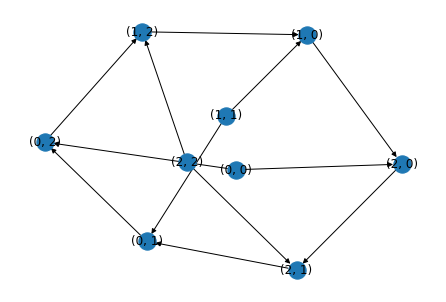

In [6]:
import networkx as nx

# transition_graph is a directed graph
transition_graph = nx.DiGraph()
# nodes of transition_graph are configurations
transition_graph.add_nodes_from(configurations)

# we visit each configuration x and add links to neighboring configurations.
# Neighboring configurations y of x are those that differ in exactly one entry,
# the action of a single player i, and such that y_i is a best response to
# x_i for player i
for configuration in configurations:
    for player in [0,1]:
        for other_action in actions:
            if other_action != configuration[player] and other_action in best_response(player,configuration):
                other_config = list(configuration)
                other_config[player] = other_action
                other_config = tuple(other_config)
                transition_graph.add_edge(configuration,other_config)
                
pos = nx.spring_layout(transition_graph)
nx.draw(transition_graph, pos=pos, with_labels=True)              

The transition graph has nodes corresponding to the $9$ game configurations and directed links which represent admissible transitions for the best response dynamics. 

> 5. Simulate the (discrete time) best response dynamics and estimate the invariant probability distribution $\pi$.

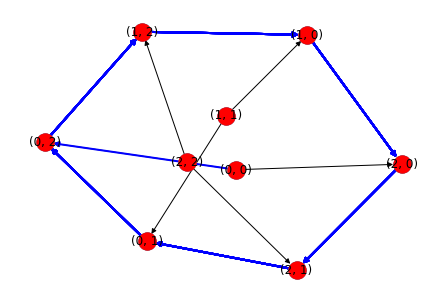

In [7]:
from numpy.random import choice, rand 

# Simulates the best response dynamics as a random walk on the transition graph G
# starting from node xi.
# if till_first_return = True the random walk stops the first time
# it returns to the starting node xi.
# Otherwise, it goes on for num_steps steps.

def RandomWalk(G, xi, num_steps, till_first_return = False):
    # nodeSeq stores the sequence of visited nodes
    nodeSeq = []
    nodeSeq.append(xi)
    
    # if the walk ends at the first return to xi
    if till_first_return:
        # stores the initial position to check if the 
        # walk returns to it
        x_init = xi
        
        while True:
            # compute the next visited node xi by chosing uniformly
            # at random a neighbor of the current one
            neighbors = list(G.neighbors(xi))
            index = choice(len(neighbors),1)[0] 
            xi = neighbors[index] 
            nodeSeq.append(xi)
            
            # check if the walk has returned to the starting node
            # if so, end the walk
            if xi == x_init:
                return nodeSeq
    
    # if the walk ends after num_steps steps
    else:
        for i in range(num_steps):
            neighbors = list(G.neighbors(xi))
            index = choice(len(neighbors),1)[0] 
            xi = neighbors[index]
            nodeSeq.append(xi)
        return nodeSeq

# Simulate the BR dynamics 
nodeSeq = RandomWalk(transition_graph, xi=(0,0), num_steps=100, till_first_return=False)
edgeSeq = [(nodeSeq[i-1], nodeSeq[i]) for i in range(1,len(nodeSeq))]

# Draw G and represent the random walk by colouring the edge sequence
# first draw all nodes and links
nx.draw(transition_graph, pos)
# then, on the previous picture, add node labels and highlight the edge sequence
nx.draw(transition_graph, pos, with_labels=True, edgelist = edgeSeq, edge_color='blue', node_color='red', width=2)


We see that the dynamics starts at configuration (R,R) (represented by (0,0)) and after one step it exit from it. Then it continue cycling over best response cycle $(0,2) \to (1,2) \to (1,0) \to (2,0) \to (2,1) \to (0,1) \to (0,2)$. In particular, it never goes back to $(0,0)$ and $(1,1),(2,2)$ are never visited.

In [8]:
# Esitimate the invariant measure pi of the BR dynamics by 
# simulating a "long" random walk

nodeSeq = RandomWalk(transition_graph, (0,0), 1000, False)


# Compute empirical frequencies

# Define a dictionary to store frequencies of visit to each node
frequencies = {node:0 for node in transition_graph.nodes}
# count the visits to each node
for node in nodeSeq:
    frequencies[node] += 1
# transform dict values to a np.array
frequencies = list(frequencies[node] for node in transition_graph.nodes) 
frequencies = np.array(frequencies, dtype="double")
# normalize the counts to obtain frequencies
frequencies /= len(nodeSeq)
print("Frequencies:", frequencies)

# Print the indices of nodes where pi is positive
print("The approximate invariant distribution is supported on nodes:")
for index,node in enumerate(transition_graph.nodes):
    if frequencies[index]>0:
        print(node)

Frequencies: [0.000999   0.16583417 0.16683317 0.16683317 0.         0.16683317
 0.16683317 0.16583417 0.        ]
The approximate invariant distribution is supported on nodes:
(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 2)
(2, 0)
(2, 1)


The approximate invariant distribution appears to be supported on nodes $\{(0,0),(0,1),(0,2),(1,0),(1,2),(2,0),(2,1)\}$ of the transition graph. However, the measure of node $(0,0)$ is negligible with respect to that of $(0,1),(0,2),(1,0),(1,2),(2,0),(2,1)$, which are almost equal to each other. Actually, the little weight associated to node $(0,0)$ appears to depend on the fact that it has been visited once since it is the starting point of the chain. We guess that when the length on the walk tends to infinity the weight associated to node $(0,0)$ vanishes and the approximation of $\pi$ is supported and uniformly distributed on $\{(0,1),(0,2),(1,0),(1,2),(2,0),(2,1)\}$.

> 6. Compute and plot the condensation graph of $\mathcal G_{B}$.

{0: {'members': {(0, 1), (1, 2), (2, 1), (2, 0), (0, 2), (1, 0)}}, 1: {'members': {(0, 0)}}, 2: {'members': {(1, 1)}}, 3: {'members': {(2, 2)}}}


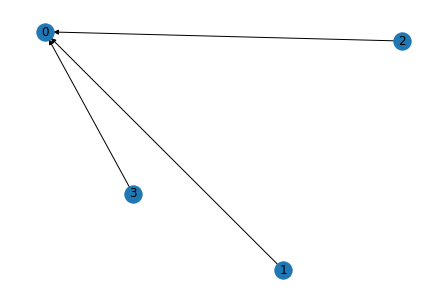

In [6]:
CG = nx.algorithms.components.condensation(transition_graph)
nx.draw(CG, with_labels=True)
print(dict(CG.nodes))

The condensation graph is shown above, where the hypernode $0$ contains all configurations except for $(R,R), (S,S), (P,P)$ (the ones that correspond to a draw). More precisely, the hypernode $0$ contains the $6$-cycle $(0,2) \to (1,2) \to (1,0) \to (2,0) \to (2,1) \to (0,1) \to (0,2)$. The hypernodes $1,2,3$ instead contain the singletons $(R,R), (S,S), (P,P)$. The condensation graph contains only one sink, that is $s_{\text{transition_graph}} = 1$.

7. Compute analytically the invariant distribution $\pi$ of the best response dynamics.

We know that the invariant probability distribution is supported on the nodes contained in the unique sink of the condensation graph. The subgraph corresponding to such sink is balanced (all nodes have in-degree $1$ and out-degree $1$, so the sink is $1$-regular), then the extremal invariant probability distribution supported on that sink is obtained by normalizing the out-degree vector. In this way we find that $\pi_x = 1/6$, for $x \in \{RS, RP, SR, SP, PR, PS\}$ and $\pi_x = 0$ for $x \in \{RR, SS, PP\}$.

We can check that this is correct with the following code.

In [7]:
# Compute P matrix
A = nx.adjacency_matrix(transition_graph) # -> return type is scipy.sparse.csr_matrix
A = A.toarray() # convert A to a numpy array
degrees = np.sum(A,axis=1)
D = np.diag(degrees)
P = np.linalg.inv(D) @ A

# Compute invariant distribution
values,vectors = np.linalg.eig(P.T)
index = np.argmax(values.real)
pi = vectors[:,index].real
pi = pi/np.sum(pi)
print("pi=", pi)

pi= [-0.          0.16666667  0.16666667  0.16666667 -0.          0.16666667
  0.16666667  0.16666667 -0.        ]


# Continuous time best response dynamics
In this section we present the continuous time best response dynamics, which is the continuous time analog of the process presented in the previous section.


Consider a game $\left(\mathcal V, \mathcal A, \{u_i\}_{i \in \mathcal V}\right)$. 

The **continuous-time asynchronous best response dynamics** is a continuous time Markov chain $X(t)$ with state space $\mathcal X= \mathcal A^{\mathcal V}$ coinciding with the configuration space of the game and transition rate matrix $\Lambda$ as follows: 

$\Lambda_{xy} = 0$ for every two configurations $x, y \in \mathcal X$ that differ in more
than one entry, and

$$
\Lambda_{xy} = \begin{cases}
|B_i(x_{-i})|^{-1} \quad \text{if} \quad y_i \in B_i(x_{-i}) \\
0 \quad \text{if} \quad y_i \notin B_i(x_{-i})
\end{cases}
$$
for every two configurations $x, y \in \mathcal X$ differing in entry $i$ only, i.e., such that
$x_i \neq y_i$ and $x_{-i} = y_{-i}$.

## Continuous time BRD for network games

Network games are games where players are associated to nodes of a graph $\mathcal G$ that describes the interactions among them. In particular, for each player $i\in\mathcal V$ and for each couple of configurations $x,y\in\mathcal A^{\mathcal V}$ such that $x_j=y_j$ for each $j\in\ N_i\cup\{i\}$ it holds that
$$u_i(x)=u_i(y)$$
This means that the utility of each player only depends on the actions of its neighbors in the graph $\mathcal G$.


Given an unweighted undirected graph $\mathcal G=(\mathcal V,\mathcal E,W)$ we can construct a network game on it by setting the players’ utilities to coincide with the weighted sum of the payoffs of the same symmetric two-player game played by the player simultaneously with her neighbors.

Specifically, for a symmetric two-player game with action set $\mathcal A$ and utility function $\varphi(x_1, x_2)$ we define the network game $(\mathcal V, \mathcal A, \{u_i\}_{i \in \mathcal V} )$ by setting the utility of every player $i \in \mathcal V$ as
$$
u_i(x) = \sum_{j \in \mathcal V} W_{ij}\varphi(x_i,x_j)
$$

## Exercise - continuous time BRD for network coordination game
A binary coordination game is a symmetric $2 \times 2$-game with action set $\mathcal A = \{0,1\}$ with payoff matrix $\varphi$

|   | 0   | 1   |
|---|-----|-----|
| **0** | a,a | d,c |
| **1** | c,d | b,b |

where $a > c$ and $b > d$. The inequalities above imply that the best response for each player is to copy the action of the other player.

It is a potential game with potential $\phi$

|   | 0   | 1   |
|---|-----|-----|
| **0** | a-c | 0 |
| **1** | 0 | b-d |

Consider the **network coordination game**, obtained combining binary coordination games on the link of the following undirected graph

![network](network.png)

Recall that such network game is potential with potential function $\Phi$
$$
\Phi(x) = \frac{1}{2} \sum_{i,j} W_{ij} \phi(x_i,x_j) .
$$

1. Simulate the dynamics when the coordination game has the same utility value for coordination of action 0 and action 1 respectively, i.e., $a=b=1$ and $c=d=0$. Run the simulation a few times and plot the potential function as a function of time. What do you observe?

**Hint**: you need to fix the best response function to deal with more than 2 players. To do this it is useful to define a Python function to represent the utility functions of the network game. You can find such function in the solution to the next exercise.

In [8]:
# TO DO

**Remark**: You should able to check the following fact.
For potential games, the best response dynamics converges to the set of Nash equilibria. More precisely, it converges to Nash equilibria that are **local maxima of the potential function**.

# Network games and Noisy Best Response dynamics
Consider the graph in Figure below, where a network coordination game takes place.
![network](network.png)

We consider a **continuous time asyncronous noisy best response  dynamics** with inverse noise parameter $\eta=2$, i.e., a continuous time Markov chain on the configuration space $\mathcal X$ (the set of all game's configurations) with transition rates $\Lambda_{xy} = 0$ for every two configurations $x, y \in \mathcal X$ that differ in more
than one entry, and

$$
\Lambda_{xy} = \frac{\exp^{\eta u_i(y_i,x_{-i})}}{\sum_{a \in \mathcal A} \exp^{\eta u_i(a,x_{-i})} }
$$
for every two configurations $x, y \in \mathcal X$ differing in entry $i$ only, i.e., such that
$x_i \neq y_i$ and $x_{-i} = y_{-i}$.


1.  Simulate the dynamics when the coordination game has the same utility value for coordination of action 0 and action 1 respectively, i.e., $a=b=1$ and $c=d=0$. Run the simulation a few times and plot the potential function as a function of time. What do you observe?
2. Simulate the dynamics when  instead $a=1$, $b=\frac{1}{2}$ and $c=d=0$. Run the simulation a few times and plot the potential function as a function of time. What do you observe?
3. If the simulation continues for a long time, will the probability for different configurations converge towards some specific values? In that case, how can these be computed?
4. Compute the ratio between the probability that after a long time (i.e., in stationarity) all nodes choose action 1 and the probability that all nodes choose action 0, both for case **1** and case **2**. Does this seem to agree with your simulations?
5. Compute the ratio between the probability that after a long time (i.e., in stationarity) one node chooses action 1 and the rest choose action 0, and the probability that all nodes choose action 0, both for case **1** and case **2**.


### Solution
#### Step 1
> Simulate the dynamics when the coordination game has the same utility value for coordination of action 0 and action 1 respectively, i.e., $a=b=1$ and $c=d=0$. Run the simulation a few times and plot the potential function as a function of time. What do you observe?

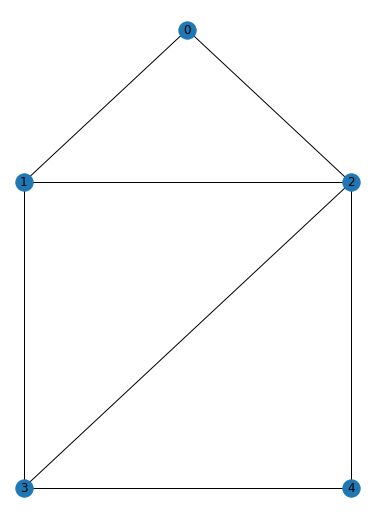

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

# Construct the undirected graph as shown in the picture
G = nx.Graph()
G.add_nodes_from(range(5))
G.add_edges_from([
    (0,1),(0,2),
    (1,2),(1,3),
    (2,3),(2,4),
    (3,4)
])

plt.figure(figsize=(5,7))
pos = {3: (0, 0), 4: (1, 0), 1: (0, 1), 2: (1, 1), 0: (0.5, 1.5)}
nx.draw(G, pos=pos, with_labels=True)

In [10]:
# Define the network coordination game

# number of nodes in G = number of players in the game
n_players = len(G)
# utility values
a = 1
b = 1
c = 0
d = 0
# utility matrix for the 2x2 coordination game
phi = np.array([[a,d],
                [c,b]])
# the potential function of the 2x2 coordination game
pot = np.array([[a-c,0],
                [0,b-d]])
# inverse noise parameter
eta = 2
# available actions
actions = [0,1]
n_actions = len(actions)
# adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

def utility(player, x, phi):
    result = 0
    for other_player in G.neighbors(player):
         result += phi[x[player], x[other_player]]
    return result

In [11]:
# Define the noisy best response dynamics

# Initialize transition rates matrix
n_config = n_actions**n_players
Lambda = sp.sparse.lil_matrix((n_config,n_config))

# Number of actions for each player
n_states =tuple(n_actions for _ in range(n_players))

# Fill transition rates matrix
for x_id in range(n_config):
    x = np.unravel_index(x_id,shape=n_states)
    x = np.array(x)
    for player in range(n_players):
        # compute utilities gained by `player` for each of its possible actions
        # while the other players are in the current configuration x
        utilities = np.zeros(n_actions)
        for action in actions:
            y = np.array(x)
            y[player] = action
            utilities[action] = utility(player,y, phi)
        exp_utilities = np.exp(eta*utilities)
        for action in actions:
            if action == x[player]:
                continue
            y = np.array(x)
            y[player] = action
            y_id = np.ravel_multi_index(tuple(y), dims = n_states)
            Lambda[x_id, y_id] += exp_utilities[action] / np.sum(exp_utilities)

In [12]:
# Simulate the continuous time Markov chain with 2nd approach: local clocks

w = np.sum(Lambda, axis=1)
w = np.array(w.T)[0]
for x, weight in enumerate(w):
    if weight == 0:
        Lambda[x,x] = 1
        w[x] = 1
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# number of iterations
n_steps = 100

states = np.zeros(n_steps, dtype=int)
# initial configuration
x = np.random.choice(actions, size = n_players)
x_id = np.ravel_multi_index(tuple(x), dims = n_states)
states[0] = x_id

transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[0]

P_cum = np.cumsum(P, axis=1)

for i in range(1,n_steps):
    states[i] = np.argwhere(P_cum[states[i-1]] > np.random.rand())[0]
    transition_times[i] = transition_times[i-1] + t_next
    t_next = -np.log(np.random.rand())/w[states[i]]

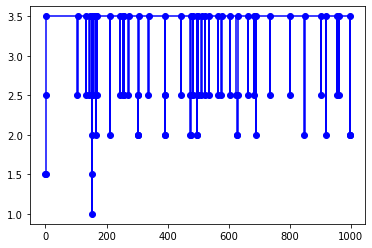

In [13]:
# Compute and plot the evolution of the potential along the simulated 
# path of the chain

# store the potential value at each step of the simulation
potentials = np.zeros(n_steps)
for step in range(n_steps):
    x_id = states[step]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    for i, j in G.edges:
        potentials[step] += 0.5*pot[x[i],x[j]]

plt.step(transition_times, potentials, 'bo-', where="post");

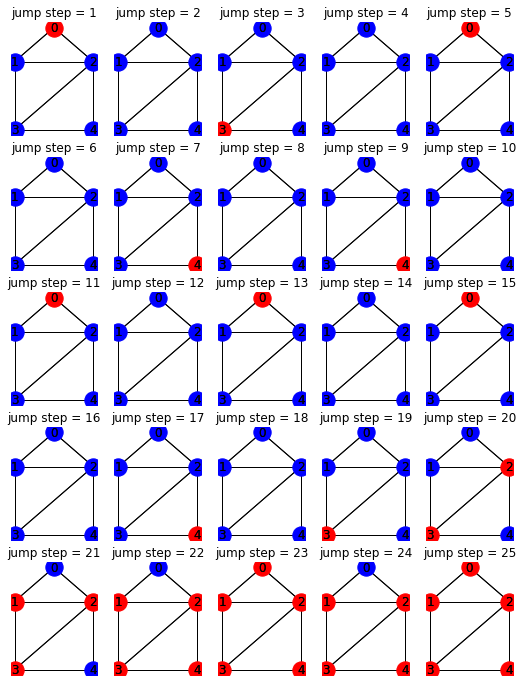

In [14]:
# To better understand the process, visualize the 
# evolution of the game's configuration in time

import matplotlib.pyplot as plt

# Plot the evolution of the game's configurations
fig = plt.figure(figsize=(9,12))
for t in range(0,min(n_steps,25)):
    plt.subplot(5,5,t+1)
    x_id = states[t]
    x = np.array(np.unravel_index(x_id, shape = n_states))
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==0).T[0].tolist(),
        node_color = 'r')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=np.argwhere(x==1).T[0].tolist(),
        node_color = 'b')
    plt.title('jump step = {0}'.format(t+1))

We can see that the potential during most of the
time is at its maximum value, corresponding to all nodes choosing the
same action. By repeating the simulation, it seems like all nodes tend
to end up in the same state after long time, independently of the initialization. The asymptotic state consists equally often in that all nodes
choose action 0 as that all nodes choose action 1.

We know from the theory that the noisy best response dynamics operates a selection among the NE and concentrates, in the small noise limit, most of the probability of its invariant distribution in the subset of those Nash equilibria that correspond to the set of potential maximizers $$\arg \max_{x \in \mathcal X} \Phi(x)$$ With the current choice for $a,b,c,d$ the maximum value of the potential $\Phi$ is realized by both the all-one and all-zero configurations.

In this example we have a fixed noisy parameter $\eta = 2$ but we are still able to observe that the dynamics spends most part of the time in global maxima of the potential.
Try to change the noise parameter and see how the dynamics behaves.

#### Step 2
> Simulate the dynamics when  instead $a=1$, $b=\frac{1}{2}$ and $c=d=0$. Run the simulation a few times and plot the potential function as a function of time. What do you observe?

The same code as previously can be reused, by only changing the parameter $b$. The simulations and the evolution of the potential values along it behave very similarly, with the difference that, among the states in which all nodes choose the same action, state $(0,\ldots,0)$ is much more frequent than $(1,\ldots,1)$. Even if all nodes are initialized to choose action 1, with high probability after a while they will all choose action 0 instead. This happens since with the current choice of $a,b,c,d$ the global maximum of the potential $\Phi$ is realized by the all-zero configuration.

In [15]:
# TO DO

#### Step 3
> If the simulation continues for a long time, will the probability to be in the different configurations converge towards some specific values? In that case, how can these be computed?

According to the theory about noisy best response dynamics, this type of dynamics is, for any choice of $\eta > 0$, an irreducible reversible Markov chain with invariant probability distribution
$$
\pi_x = \frac{e^{\eta \Phi(x)}}{Z_\eta}, \quad Z_\eta = \sum_{y\in \mathcal{X}} e^{\eta \Phi(y)}.
\tag{1}
$$

Compute the values of $\pi$.

In [16]:
# TO DO

#### Step 4
> Compute the ratio between the probability that after a long time (i.e., in stationarity) all nodes choose action 1 and the probability that all nodes choose action 0, both for case **1** and case **2**. Does this seem to agree with your simulations?

According to (1), we have that 
$$
\frac{\pi_{(1,1,1,1,1)}}{\pi_{(0,0,0,0,0)}} = \frac{e^{\eta \Phi(1,1,1,1,1)}}{e^{\eta \Phi(0,0,0,0,0)}}.
$$
We can thus compute the result according to the following code: 

In [17]:
print("Case 1:")
# utility values
a = 1
b = 1
c = 0
d = 0
# the potential function of the 2x2 game
pot = np.array([[a-c,0],
                [0,b-d]])
x_0 = [0 for node in G]
potential_0 = 0
for i, j in G.edges:
    potential_0 += 0.5*pot[x_0[i],x_0[j]]

x_1 = [1 for node in G]
potential_1 = 0
for i, j in G.edges:
    potential_1 += 0.5*pot[x_1[i],x_1[j]]

probability_ratio_1_over_0 = np.exp(eta*potential_1) / np.exp(eta*potential_0)
print("The ratio between the probability of configuration 'all ones' and configuration 'all zeros' is", probability_ratio_1_over_0)

print("Case 2:")

# utility values
a = 1
b = 1/2
c = 0
d = 0
# the potential function of the 2x2 game
pot = np.array([[a-c,0],
                [0,b-d]])

x_0 = [0 for node in G]
potential_0 = 0
for i, j in G.edges:
    potential_0 += 0.5*pot[x_0[i],x_0[j]]

x_1 = [1 for node in G]
potential_1 = 0
for i, j in G.edges:
    potential_1 += 0.5*pot[x_1[i],x_1[j]]

probability_ratio_1_over_0 = np.exp(eta*potential_1) / np.exp(eta*potential_0)
print("The ratio between the probability of configuration 'all ones' and configuration 'all zeros' is", probability_ratio_1_over_0)


Case 1:
The ratio between the probability of configuration 'all ones' and configuration 'all zeros' is 1.0
Case 2:
The ratio between the probability of configuration 'all ones' and configuration 'all zeros' is 0.0301973834223185


Check if this result agree with your simulations by estimating $\pi$ for case **1** and **2** by measuring the time spent in each configuration.

**Hint:** exploit the code for continuous time Markov chains from Lab04, where we kept trace of time intervals spent in each configuration during the simulation.

#### Step 5. 
> Compute the ratio between the probability that after a long time (i.e., in stationarity) one node chooses action 1 and the rest choose action 0, and the probability that all nodes choose action 0, both for case **1** and case **2**.

Using the invariant probability distribution formula (1) again, we can compute the ratio
$$
\frac{\sum_{i \in \mathcal V} \pi_{\delta(i)}}{\pi_{(0,0,0,0,0)}}
$$
where $\delta(i)_i=1$ and $\delta(i)_j=0$, $\forall j \neq i$.

In [18]:
print("Case 1:")
# utility values
a = 1
b = 1
c = 0
d = 0
# the potential function of the 2x2 game
pot = np.array([[a-c,0],
                [0,b-d]])
x_0 = [0 for node in G]
potential_0 = 0
for i, j in G.edges:
    potential_0 += 0.5*pot[x_0[i],x_0[j]]

exp_potential_1 = 0
for player in G:
    x_1 = [0 for node in G]
    x_1[player] = 1
    potential_1 = 0
    for i, j in G.edges:
        potential_1 += 0.5*pot[x_1[i],x_1[j]]
    exp_potential_1 += np.exp(eta*potential_1)

# print(exp_potential_1)
probability_ratio_1_over_0 = exp_potential_1 / np.exp(eta*potential_0)
print("The ratio between the probability of configuration 'one one, rest zero' and configuration 'all zeros' is", probability_ratio_1_over_0)

print("Case 2:")

# utility values
a = 1
b = 1/2
c = 0
d = 0
# the potential function of the 2x2 game
pot = np.array([[a-c,0],
                [0,b-d]])

x_0 = [0 for node in G]
potential_0 = 0
for i, j in G.edges:
    potential_0 += 0.5*pot[x_0[i],x_0[j]]

exp_potential_1 = 0
for player in G:
    x_1 = [0 for node in G]
    x_1[player] = 1
    potential_1 = 0
    for i, j in G.edges:
        potential_1 += 0.5*pot[x_1[i],x_1[j]]
    exp_potential_1 += np.exp(eta*potential_1)

# print(exp_potential_1)
probability_ratio_1_over_0 = exp_potential_1 / np.exp(eta*potential_0)
print("The ratio between the probability of configuration 'one one, rest zero' and configuration 'all zeros' is", probability_ratio_1_over_0)


Case 1:
The ratio between the probability of configuration 'one one, rest zero' and configuration 'all zeros' is 0.3885603420976875
Case 2:
The ratio between the probability of configuration 'one one, rest zero' and configuration 'all zeros' is 0.3885603420976875


Even if in case 1 and 2 are different, the ratio 
$$
\frac{\sum_{i \in \mathcal V} \pi_{\delta(i)}}{\pi_{(0,0,0,0,0)}}
$$
is the same in the two cases.
This happens because the potential value of configurations $\delta(i)$ and $(0,0,0,0,0)$ does not depends on $b$, as the configurations does not contain any couple of neighboring players playing action $1$.